# Pha test của các thuật toán

In [25]:

REWARD_DROP=[-1]
algorithms=['local','distance','queue','Round_Robin']
colors = ['blue', 'red', 'green', 'black','orange','yellow']

d:\Lab\Vfogsim\Python_code
Mean : 417.68923712858646
Mean : 417.68923712858646
Mean : 1152.4716830682044


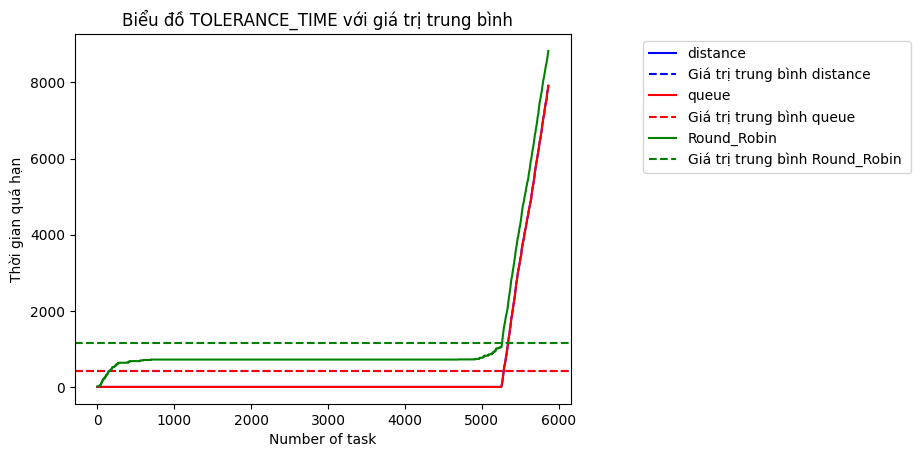

In [22]:
  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path

LINK_PROJECT = Path(os.path.abspath('draw_plot.ipynb')).parent.parent
print(LINK_PROJECT)
result=dict()
result_info=dict()
j=0
for algorithm in algorithms:
    with open(f"{LINK_PROJECT}/result/test/poisson/{algorithm}/sum_tolerance_time.csv", "r") as file:
        result[algorithm] = pd.read_csv(file)
    columns = ['sum_tolerance_time'][0]

    minrange = 0
    maxrange = -1

    result_info[algorithm] = result[algorithm][columns][minrange:maxrange]
    plt.plot(result_info[algorithm],color=colors[j], label = f"{algorithm}")
    plt.axhline(np.mean(result_info[algorithm]),color=colors[j], linestyle='--', label=f'Giá trị trung bình {algorithm} ')
    print(f"Mean :", np.mean(result_info[algorithm]))
    j+=1

plt.xlabel('Number of task')
plt.ylabel('Thời gian quá hạn')
        # plt.ylim(-0.05, -0)
plt.title( f'Biểu đồ TOLERANCE_TIME với giá trị trung bình  ')
plt.legend(loc='upper right',bbox_to_anchor=(1.7, 1), ncol=1, fancybox=True)
# plt.savefig(f"{LINK_PROJECT}/fig/{which_algorithm}/env_2_4/5vehicle/{NUMS_TASK}task/num_iters{iters}/eps{eps}/Biểu đồ TOLERANCE_TIME với giá trị trung bình trong pha Test-{which_algorithm}-reward_drop:{reward_drop}.png")
plt.show()

d:\Lab\Vfogsim\Python_code
Mean local : -12.623097626350111
Mean distance : -0.07384822856113432
Mean queue : -0.07384822856113432
Mean Round_Robin : -0.5591708786724904


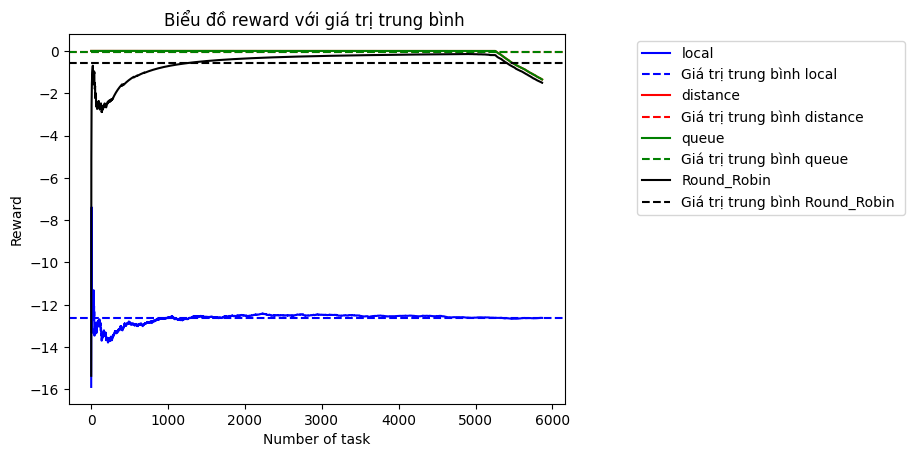

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path

LINK_PROJECT = Path(os.path.abspath('draw_plot.ipynb')).parent.parent
print(LINK_PROJECT)
result=dict()
result_info=dict()
j=0
for algorithm in algorithms:
    with open(f"{LINK_PROJECT}/result/test/log_normal/{algorithm}/reward.csv", "r") as file:
        result[algorithm] = pd.read_csv(file)
    columns = ['reward'][0]

    minrange = 0
    maxrange = -1

    result_info[algorithm] = result[algorithm][columns][minrange:maxrange]
    plt.plot(result_info[algorithm],color=colors[j], label = f"{algorithm}")
    plt.axhline(np.mean(result_info[algorithm]),color=colors[j], linestyle='--', label=f'Giá trị trung bình {algorithm} ')
    print(f"Mean {algorithm} :", np.mean(result_info[algorithm]))
    j+=1

plt.xlabel('Number of task')
plt.ylabel('Reward')
        # plt.ylim(-0.05, -0)
plt.title( f'Biểu đồ reward với giá trị trung bình ')
plt.legend(bbox_to_anchor=(1.7, 1), ncol=1, fancybox=True)
# plt.savefig(f"{LINK_PROJECT}/fig/{which_algorithm}/env_2_4/5vehicle/{NUMS_TASK}task/num_iters{iters}/eps{eps}/Biểu đồ TOLERANCE_TIME với giá trị trung bình trong pha Test-{which_algorithm}-reward_drop:{reward_drop}.png")
plt.show()

D:\Lab\Vfogsim\Python_code\Functions
(5883, 4)


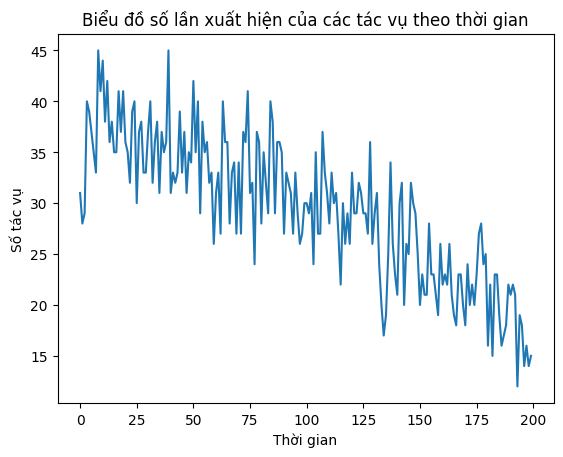

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import time
from pathlib import Path

link=os.path.join(r'D:\Lab\Vfogsim\Python_code\Functions')
sys.path.append(link)
print(link)
from preprocess import preprocess
from UserMatrix_Func_rl import UserMatrix_Func
from Ozgur_User_driven_event_rl import Ozgur_User_driven_event
from Scheduler import Scheduler
from Default_CellUpdate import Default_CellUpdate
 # assuming preprocess is a custom function or module
from config import *
from memory_profiler import profile
import torch
from numba import jit, cuda 
from metric import *
from geopy.distance import geodesic
from pyproj import Proj, transform




source = "100"  # Dataset
EventRate = 0.8  # Less is more! varies between 0.5 =>1.1
servicediff = 0
traffic = preprocess("Input.csv", source)
traffic = np.array(traffic)
traffic = np.delete(traffic, 0, 1)
traffic = np.delete(traffic, 0, 0)
# traffic[:, 1] += 1

bus = preprocess("bus.csv", source)
bus = np.array(bus)
bus = np.delete(bus, 0, 1)
bus = np.delete(bus, [2,3,4,7], 1)
# bus[:, :2] += 1
id_values = bus[:, 1]
bus_number=len(np.unique(id_values))
bus_dict=dict()
for id in range(bus_number):
    bus_dict[id]=bus[bus[:,1]==id]
NUM_VEHICLE=bus_number
# print(bus_dict.keys())

# Duration of simulation & users -- upperbounds
TimeFilter = 200
UserFilter = 500
Simulation_Duration = traffic[-1, 0]+1
USERCOUNT = max(traffic[:, 1])+1
CELLCOUNT = max(traffic[:, -1])
USERCOUNT = min(USERCOUNT, UserFilter)
Simulation_Duration = min(Simulation_Duration, TimeFilter)


# SIMULATION PARAMETERS

# AUXILIARY VARIABLES
SINR_loc = 0
SpectralResources_loc = 1
Demand_Time_loc = 2
Demand_Resource_loc = 3
Demand_ServiceType_loc = 4
Cell_ID_loc = 5
IsBlocked_loc = 6
Rem_Time_loc = 7
X_loc = 8
Y_loc = 9
Speed_loc = 10
s_in = 11
s_out = 12
Cell_Change_loc = 13
CELLCOUNT=int(CELLCOUNT)
USERCOUNT=int(USERCOUNT)
CellMatrix = np.zeros((CELLCOUNT, 3, Simulation_Duration),dtype=float)
B_pow = 100  # if it is 0 - no fog devices on buses

UserMatrix = UserMatrix_Func(USERCOUNT, Simulation_Duration, traffic, SINR_loc, Cell_ID_loc, X_loc, Y_loc, Speed_loc, 14)

# THE EVENT GENERATION ~ PER TTI
events = np.zeros((1, 4))
for n in range(Simulation_Duration):
    port = UserMatrix[:, Cell_ID_loc, n] > 0
    dummy = Ozgur_User_driven_event(np.sum(port, 0), 3, 1, 1, EventRate, UserMatrix[:, Cell_ID_loc, n] > 0)
    dummy = np.transpose(dummy)
    dummy = dummy[~np.any(dummy == 0, axis=1)]
    dummy[:, 0] = n
    events = np.vstack((events, dummy))
events = np.delete(events, 0, 0)
print(events.shape)
x=dict()
for i in range(events.shape[0]):
    time_slot = int(events[i, 0])
    if time_slot in x:
        x[time_slot]+=1
    else:
        x[time_slot]=1
gia_tri = list(x.keys())
so_lan = list(x.values())

plt.plot(gia_tri, so_lan)
plt.xlabel('Thời gian')
plt.ylabel('Số tác vụ')
plt.title('Biểu đồ số lần xuất hiện của các tác vụ theo thời gian')
plt.show()